## Machine Learning with Spark - Lab

## Introduction

Previously you saw how to manipulate data with Spark DataFrames as well as create machine learning models. In this lab, you're going to practice loading data, manipulating it, preparing visualizations, and fitting it in the Spark MLlib framework. Let's get started!

### Objectives

In this lab you will: 

- Load and manipulate data using Spark DataFrames 
- Create a Spark ML pipeline that transforms data and runs over a grid of hyperparameters 

## The Data

This dataset is from a Taiwanese financial company, and the task is to determine which individuals are going to default on their credit card based off of characteristics such as limit balance, past payment history, age, marriage status, and sex.

You'll use the file `credit_card_default.csv`, which comes from the [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients).

## Initial Data Exploration

Get started by writing the relevant import statement and creating a local SparkSession called `spark`, then use that SparkSession to read `credit_card_default.csv` into a Spark SQL DataFrame.

In [ ]:
# import necessary libraries

# initialize Spark Session
spark = None

# read in csv to a spark dataframe
spark_df = None

In [1]:
# __SOLUTION__ 
# import necessary libraries
from pyspark.sql import SparkSession
# initialize Spark Session
spark = SparkSession.builder.master('local').getOrCreate()

# read in csv to a spark dataframe
spark_df = spark.read.csv('credit_card_default.csv', header='true', inferSchema='true')

Use `.head()` to display the first 5 records, and print out the schema.

In [ ]:
# Display the first 5 records


In [2]:
# __SOLUTION__
# Display the first 5 records
spark_df.head(5)

[Row(ID=2, LIMIT_BAL=120000.0, SEX='Female', EDUCATION='College', MARRIAGE='Single', AGE=26, PAY_0=-1, PAY_2=2, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=2, BILL_AMT1=2682.0, BILL_AMT2=1725.0, BILL_AMT3=2682.0, BILL_AMT4=3272.0, BILL_AMT5=3455.0, BILL_AMT6=3261.0, PAY_AMT1=0.0, PAY_AMT2=1000.0, PAY_AMT3=1000.0, PAY_AMT4=1000.0, PAY_AMT5=0.0, PAY_AMT6=2000.0, default=1),
 Row(ID=3, LIMIT_BAL=90000.0, SEX='Female', EDUCATION='College', MARRIAGE='Single', AGE=34, PAY_0=0, PAY_2=0, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=0, BILL_AMT1=29239.0, BILL_AMT2=14027.0, BILL_AMT3=13559.0, BILL_AMT4=14331.0, BILL_AMT5=14948.0, BILL_AMT6=15549.0, PAY_AMT1=1518.0, PAY_AMT2=1500.0, PAY_AMT3=1000.0, PAY_AMT4=1000.0, PAY_AMT5=1000.0, PAY_AMT6=5000.0, default=0),
 Row(ID=4, LIMIT_BAL=50000.0, SEX='Female', EDUCATION='College', MARRIAGE='Married', AGE=37, PAY_0=0, PAY_2=0, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=0, BILL_AMT1=46990.0, BILL_AMT2=48233.0, BILL_AMT3=49291.0, BILL_AMT4=28314.0, BILL_AMT5=28959.0, BILL_AMT6=29547.0, P

In [ ]:
# Print out the schema


In [3]:
# __SOLUTION__
# Print out the schema
spark_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: double (nullable = true)
 |-- SEX: string (nullable = true)
 |-- EDUCATION: string (nullable = true)
 |-- MARRIAGE: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: double (nullable = true)
 |-- BILL_AMT2: double (nullable = true)
 |-- BILL_AMT3: double (nullable = true)
 |-- BILL_AMT4: double (nullable = true)
 |-- BILL_AMT5: double (nullable = true)
 |-- BILL_AMT6: double (nullable = true)
 |-- PAY_AMT1: double (nullable = true)
 |-- PAY_AMT2: double (nullable = true)
 |-- PAY_AMT3: double (nullable = true)
 |-- PAY_AMT4: double (nullable = true)
 |-- PAY_AMT5: double (nullable = true)
 |-- PAY_AMT6: double (nullable = true)
 |-- default: integer (nullable = true)



It looks like we have three non-numeric features. For each non-numeric (`string`) feature, select and show all distinct categories.

In [ ]:
# Select and show all distinct categories


In [4]:
# __SOLUTION__
# Select and show all distinct categories

# Loop over all column dtypes and display information if
# the dtype is 'string'
# (Alternatively you could just list out the column names)
for column, data_type in spark_df.dtypes:
    if data_type == 'string':
        # Select and show distinct values in that column
        spark_df.select(column).distinct().show()

+------+
|   SEX|
+------+
|Female|
|  Male|
+------+

+-----------+
|  EDUCATION|
+-----------+
|High School|
|          0|
|          5|
|          6|
|      Other|
|   Graduate|
|    College|
+-----------+

+--------+
|MARRIAGE|
+--------+
|       0|
|   Other|
| Married|
|  Single|
+--------+



Interesting...it looks like we have some extraneous values in our categories. For example both `EDUCATION` and `MARRIAGE` have a category `0`.

Let's create some visualizations of each of these to determine just how many of them there are.

Create bar plots of the variables `EDUCATION` and `MARRIAGE` to see how the records are distributed between the categories.

<details>
    <summary><u>Click to reveal hint</u></summary>
    
To create a bar plot, you need to group by the category (`.groupBy()`) and then aggregate by the count in that category (`.count()`). That will result in a small DataFrame containing `EDUCATION` and `count` columns.
    
Then the easiest way to create a bar plot is to call `.toPandas()` to make that small Spark SQL DataFrame into a pandas DataFrame, and call `.plot()` on the pandas DataFrame.

</details>

In [ ]:
# Create bar plot of EDUCATION


+-----------+-----+
|  EDUCATION|count|
+-----------+-----+
|High School| 4917|
|          0|   14|
|          5|  280|
|          6|   51|
|      Other|  123|
|   Graduate|10585|
|    College|14029|
+-----------+-----+



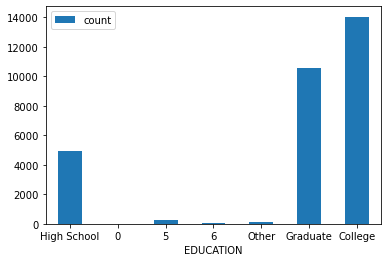

In [5]:
# __SOLUTION__
# Create bar plot of EDUCATION
# First, aggregate data
education_cats = spark_df.groupBy('EDUCATION').count()
education_cats.show()
# Then plot data
education_cats.toPandas().plot(x="EDUCATION", y="count", kind="bar", rot=0);

In [ ]:
# Create bar plot of MARRIAGE


+--------+-----+
|MARRIAGE|count|
+--------+-----+
|       0|   54|
|   Other|  323|
| Married|13658|
|  Single|15964|
+--------+-----+



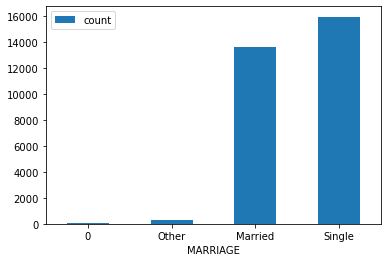

In [6]:
# __SOLUTION__
# Create bar plot of MARRIAGE
# First, aggregate data
marriage_cats = spark_df.groupby('MARRIAGE').count()
marriage_cats.show()
# Then plot data
marriage_cats.toPandas().plot(x="MARRIAGE", y="count", kind="bar", rot=0);

## Binning

It looks like there are barely any records in the `0`, `5`, and `6` categories. Let's go ahead and bin (combine) those with the current `Other` records into a single catch-all `Other` category for both `EDUCATION` and `MARRIAGE`.

The approach we'll use is similar to the `CASE WHEN` technique in SQL. If this were a SQL query, it would look something like this:

```sql
SELECT CASE
       WHEN EDUCATION = '0' THEN 'Other'
       WHEN EDUCATION = '5' THEN 'Other'
       WHEN EDUCATION = '6' THEN 'Other'
       ELSE EDUCATION
       END AS EDUCATION
  FROM credit_card_default;
```

With Spark SQL DataFrames, this is achieved using `.withColumn()` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.withColumn.html)) in conjunction with `.when()` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.when.html)) and `.otherwise()` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.otherwise.html)).

In [ ]:
# Bin EDUCATION categories

# Bin MARRIAGE categories

# Select and show all distinct categories for EDUCATION and MARRIGE again


In [7]:
# __SOLUTION__
from pyspark.sql import functions as F
# Bin EDUCATION categories
df_education_binned = spark_df.withColumn('EDUCATION',
                                          F.when(spark_df['EDUCATION'] == '0', 'Other')\
                                          .when(spark_df['EDUCATION'] == '5', 'Other')\
                                          .when(spark_df['EDUCATION'] == '6', 'Other')\
                                          .otherwise(spark_df['EDUCATION'])
                                         )
# Bin MARRIAGE categories
df_all_binned = df_education_binned.withColumn('MARRIAGE',
                                               F.when(df_education_binned['MARRIAGE'] == '0', 'Other')\
                                               .otherwise(df_education_binned['MARRIAGE'])
                                              )

# Select and show all distinct categories for EDUCATION and MARRIGE again
df_all_binned.select('EDUCATION').distinct().show()
df_all_binned.select('MARRIAGE').distinct().show()

+-----------+
|  EDUCATION|
+-----------+
|High School|
|      Other|
|   Graduate|
|    College|
+-----------+

+--------+
|MARRIAGE|
+--------+
|   Other|
| Married|
|  Single|
+--------+



Let's also re-create the plots from earlier, now that the data has been binned:

In [ ]:
# Plot EDUCATION


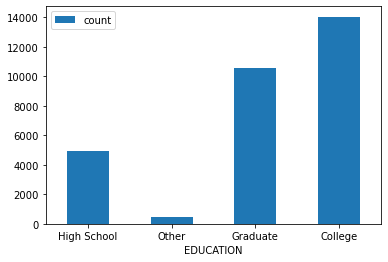

In [8]:
# __SOLUTION__
# Plot EDUCATION
df_all_binned.groupBy('EDUCATION')\
             .count()\
             .toPandas()\
             .plot(x="EDUCATION", y="count", kind="bar", rot=0);

In [ ]:
# Plot MARRIAGE


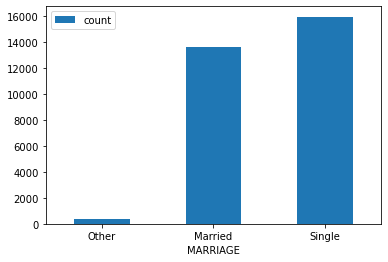

In [9]:
# __SOLUTION__
# Plot MARRIAGE
df_all_binned.groupBy('MARRIAGE')\
             .count()\
             .toPandas()\
             .plot(x="MARRIAGE", y="count", kind="bar", rot=0);

Much better. Now, let's do a little more investigation into our target variable before diving into the machine learning aspect of this project.

##  Class Balance Exploration

Let's first look at the overall distribution of class balance of the `default` column (the target for our upcoming machine learning process). 

Create a bar plot to compare the number of defaults (`0`) vs. non-defaults (`1`). Consider customizing your plot labels as well, since `0` and `1` are not particularly understandable values.

In [ ]:
# Group and aggregate target data

# Plot target data


+-------+-----+
|default|count|
+-------+-----+
|      0|23364|
|      1| 6635|
+-------+-----+



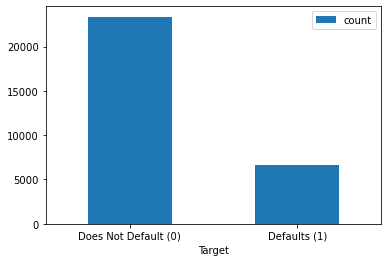

In [10]:
# __SOLUTION__
import matplotlib.pyplot as plt

# Group and aggregate target data
target_cats = df_all_binned.groupBy('default').count().orderBy('default')
target_cats.show()

# Plot target data
fig, ax = plt.subplots()
target_cats.toPandas().plot(x='default', y='count', kind='bar', ax=ax, rot=0)
ax.set_xlabel("Target")
ax.set_xticklabels(['Does Not Default (0)','Defaults (1)']);

Looks like we have a fairly imbalanced dataset.

Let's also visualize the difference in default rate between males and females in this dataset. Group by both `default` and `SEX` and visualize the comparison.

In [ ]:
# Group and aggregate target and sex data

# Plot target and sex data


+-------+------+-----+
|default|   SEX|count|
+-------+------+-----+
|      0|Female|14349|
|      0|  Male| 9015|
|      1|Female| 3762|
|      1|  Male| 2873|
+-------+------+-----+



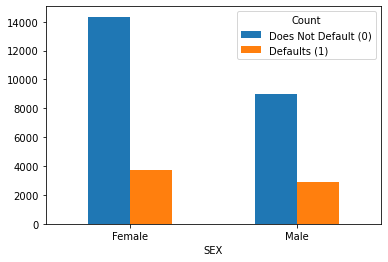

In [11]:
# __SOLUTION__
# Group and aggregate target and sex data
target_by_sex = df_all_binned.groupBy(['default', 'SEX']).count().orderBy(['default', 'SEX'])
target_by_sex.show()

# Plot target and sex data
fig, ax = plt.subplots()

target_by_sex.toPandas().pivot('SEX', 'default')\
               .plot(kind='bar', ax=ax, rot=0)

ax.legend(title="Count", labels=['Does Not Default (0)','Defaults (1)']);

It looks like males have an ever so slightly higher default rate than females, and also represent a smaller proportion of the dataset.

## On to the Machine Learning!

Now, it's time to fit the data to the PySpark machine learning model pipeline. You will need:

* 3 `StringIndexer`s
  * One for each categorical feature
  * [Documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html)
* A `OneHotEncoder`
  * To encode the newly indexed strings into categorical variables
  * [Documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.OneHotEncoder.html)
* A `VectorAssembler`
  * To combine all features into one `SparseVector`
  * [Documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.VectorAssembler.html)

All of these initialized estimators should be stored in a list called `stages`.

In [ ]:
# Import the necessary classes


# Create the string indexers and determine the names of the numeric
# and indexed columns. Note that ID is an identifier and should NOT
# be included in the numeric columns


# Create a OneHotEncoder to encode the indexed string features


# Determine the names of the final list of features going into the model


# Create a VectorAssembler to combine all features


# Assemble a list of stages that includes all indexers, the one-hot
# encoder, and the vector assembler


In [12]:
# __SOLUTION__ 
# Import the necessary classes
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

# Create the string indexers and determine the names of the numeric
# and indexed columns
# (You could write this out for all 3 but we'll use a loop approach)
indexers = []
indexed_features = []
numeric_features = []

for column, data_type in df_all_binned.dtypes:
    if data_type == 'string':
        # Create StringIndexers for columns containing strings
        si = StringIndexer(inputCol=column, outputCol=column+'_num', handleInvalid='keep')
        indexers.append(si)
        # Save the name of the output column to sent to the OHE
        indexed_features.append(si.getOutputCol())
    elif column != "ID" and column != "default":
        # Unless it's ID (an identifier rather than a genuine feature),
        # append to list of numeric features if the dtype isn't string
        numeric_features.append(column)

print("Indexed string features:", indexed_features, "\n")
print("Numeric features:", numeric_features, "\n")

# Create a OneHotEncoder to encode the indexed string features
ohe = OneHotEncoder(
    inputCols=indexed_features,
    outputCols=[col + '_ohe' for col in indexed_features],
    dropLast=True
)

# Determine the names of the final list of features going into the model
features = numeric_features + ohe.getOutputCols()
print("Final features:", features, "\n")

# Create a VectorAssembler to combine all features
va = VectorAssembler(inputCols=features , outputCol='features')

# Assemble a list of stages that includes all indexers, the one-hot
# encoder, and the vector assembler
stages = indexers + [ohe, va]
print("Stages:", stages)

Indexed string features: ['SEX_num', 'EDUCATION_num', 'MARRIAGE_num'] 

Numeric features: ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'] 

Final features: ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_num_ohe', 'EDUCATION_num_ohe', 'MARRIAGE_num_ohe'] 

Stages: [StringIndexer_d92ae283241f, StringIndexer_e1228fd05682, StringIndexer_1b597b9a8d6c, OneHotEncoder_2bc4e5f3ade8, VectorAssembler_2582c811ebfb]


Great! Now let's see if that worked. Let's investigate how it transforms your dataset. Put all of the stages in a Pipeline and fit it to your data. Look at the features column. Did you obtain the number of features you expected?

In [ ]:
# Import relevant class


# Instantiate a pipeline using stages list


# Fit and transform the data using the pipeline, then look at
# the size of the array in the 'features' column


In [13]:
# __SOLUTION__
# Import relevant class
from pyspark.ml.pipeline import Pipeline

# Instantiate a pipeline using stages list
pipe = Pipeline(stages=stages)

# Fit and transform the data using the pipeline, then look at
# the size of the array in the 'features' column
pipe.fit(df_all_binned)\
    .transform(df_all_binned)\
    .head()['features'].size

29

<details>
    <summary><u>Click to reveal answer</u></summary>
    
The pipeline should have produced a sparse vector with 29 features.

This comes from:
    
* 20 numeric features
* 3 one-hot encoded features with `dropLast=True`, containing
  * 1 SEX feature
  * 3 EDUCATION features
  * 2 MARRIAGE features

</details>

## Fitting Machine Learning Models
That looks good! Now let's go ahead and fit data to different machine learning models. To evaluate these models, you should use the `BinaryClassificationEvaluator`.

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol='prediction',
    labelCol='default',
    metricName='areaUnderROC'
)

In [14]:
# __SOLUTION__
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(
    rawPredictionCol='prediction',
    labelCol='default',
    metricName='areaUnderROC'
)

### Logistic Regression

First, we'll try a `LogisticRegression` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html)):

* split the data into a train and test set. The basic structure of this is:
```
train, test = df.randomSplit(weights=[0.8, 0.2], seed=1)
```
  * make sure you replace `df` with the actual name of your prepared dataframe
* instantiate a logistic regression with `standardization=True` and add it to the stages list
* instantiate a new Pipeline estimator with all of the stages
* fit the pipeline on the training data
* transform both train and test data using the pipeline
* use `evaluator` to evaluate performance on train vs. test

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Your code here


In [15]:
# __SOLUTION__
from pyspark.ml.classification import LogisticRegression

# Train-test split
train, test = df_all_binned.randomSplit(weights=[0.8, 0.2], seed=1)

# Instantiate a logistic regression and add to stages
lr = LogisticRegression(
    featuresCol='features',
    labelCol='default',
    predictionCol='prediction',
    standardization=True
)
lr_stages = stages + [lr]

# Instantiate a new Pipeline with all of the stages
lr_pipe = Pipeline(stages=lr_stages)

# Fit the pipeline on the training data
lr_pipe_fit = lr_pipe.fit(train)

# Transform both train and test data using the pipeline
lr_result_train = lr_pipe_fit.transform(train)
lr_result_test = lr_pipe_fit.transform(test)

# Use evaluator to evaluate performance
print("ROC-AUC on train:", evaluator.evaluate(lr_result_train))
print("ROC-AUC on test:", evaluator.evaluate(lr_result_test))

ROC-AUC on train: 0.6058470056674641
ROC-AUC on test: 0.6090136625813551


Looks like the defaults for `LogisticRegression` are working pretty well, since the train and test metrics are pretty similar.

Still, let's try a `CrossValidator` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html)) + `ParamGridBuilder` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html)) approach with a few different regularization parameters.

We'll use these regularization parameters:

```python
[0.0, 0.01, 0.1, 1.0]
```

In the cell below:

* instantiate a `ParamGridBuilder` that tests out the `regParam` values listed above
* instantiate a `CrossValidator` that uses the param grid you just created as well as `evaluator` and the pipeline you created earlier
* fit the `CrossValidator` on the full DataFrame
* display the metrics for all models, and identify the best model parameters

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Your code here


In [16]:
# __SOLUTION__
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Set up param grid
lr_params = ParamGridBuilder().addGrid(lr.regParam, [0.0, 0.01, 0.1, 1.0]).build()

# Set up cross validator
lr_cv = CrossValidator(
    estimator=lr_pipe,
    estimatorParamMaps=lr_params,
    evaluator=evaluator
)

# Fit cross validator on the full dataframe
lr_model = lr_cv.fit(df_all_binned)

In [17]:
# __SOLUTION__
# Display metrics
lr_model.avgMetrics

[0.6055782222523545,
 0.5966973737666467,
 0.5575641486263085,
 0.5047093265584573]

In [18]:
# __SOLUTION__
# Best model was the first (0-th) one
# (You could also use np.argmax to get this automatically
# instead of manually inspecting the results)
lr_params[0]

{Param(parent='LogisticRegression_ffb66ca06c66', name='regParam', doc='regularization parameter (>= 0).'): 0.0}

Now try this again with other classifiers. Try and create a function that will allow you to easily test different models with different parameters. You can find all of the available classification model options [here](https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html#classification).

This function is optional, but it should allow for your code to be far more D.R.Y. The function should return the fitted cross-validated classifier as well as print out the AUC of the best-performing model and the best parameters.

In [ ]:
# Create a function to cross validate different classifiers with different parameters



In [19]:
# __SOLUTION__
import numpy as np

def create_model(df, preprocessing_stages, classifier, param_grid, evaluator):
    # Fit the cross validator model
    stages_with_classifier = preprocessing_stages + [classifier]
    pipe = Pipeline(stages=stages_with_classifier)
    cv = CrossValidator(
        estimator=pipe,
        estimatorParamMaps=param_grid,
        evaluator=evaluator
    )
    model = cv.fit(df)
    
    # Find and display the best classifier's metric and params
    index_best_clf = np.argmax(model.avgMetrics)
    best_clf_metric = model.avgMetrics[index_best_clf]
    best_clf_params = param_grid[index_best_clf]
    print(f"""
Best {evaluator.getMetricName()}: {best_clf_metric}

Best params: {best_clf_params}
    """)
    
    # Return the model
    return model

Now train one other classifier that is not a `LogisticRegression`. Use a `ParamGridBuilder` to try out some relevant parameters.

In [ ]:
# Your code here
# ⏰ This cell may take a long time to run


In [20]:
# __SOLUTION__
# Here we're trying a random forest
# ⏰ This cell may take a long time to run
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol='features',labelCol='default')
rf_params = ParamGridBuilder()\
 .addGrid(rf.maxDepth, [5,10])\
 .addGrid(rf.numTrees, [20,100])\
 .build()

rf_model = create_model(df_all_binned, stages, rf, rf_params, evaluator)


Best areaUnderROC: 0.6532638868569178

Best params: {Param(parent='RandomForestClassifier_7e86fedddfc5', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10, Param(parent='RandomForestClassifier_7e86fedddfc5', name='numTrees', doc='Number of trees to train (>= 1).'): 100}
    


And one more:

In [ ]:
# Your code here
# ⏰ This cell may take a long time to run


In [21]:
# __SOLUTION__
# Here we're trying a gradient-boosted trees classifier
# ⏰ This cell may take a long time to run
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(featuresCol='features',labelCol='default')
gb_params = ParamGridBuilder()\
  .addGrid(gb.maxDepth,[1,5])\
  .addGrid(gb.maxIter,[20,50])\
  .build()

gb_model = create_model(df_all_binned, stages, gb, gb_params, evaluator)


Best areaUnderROC: 0.6559347316917458

Best params: {Param(parent='GBTClassifier_001ee491ee50', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5, Param(parent='GBTClassifier_001ee491ee50', name='maxIter', doc='max number of iterations (>= 0).'): 50}
    


Which classifier turned out to be the best overall?

In [ ]:
# Your answer here
"""

""";

In [ ]:
# __SOLUTION__
"""
Looking at our metrics, the gradient-boosted trees classifier
and random forest classifier had very similar metrics, with
ROC-AUC just above 0.65. Either would be a strong choice if
we aren't worried about computational complexity

The logistic regression, with ROC-AUC of 0.61, could be our
backup plan if we need a less-complex model
""";

## Level Up (Optional)

* Create ROC curves for each of these models
* Try the multi-layer perceptron classifier algorithm. You will soon learn about what this means in the neural network section!

## Stop the Spark Session

In [ ]:
spark.stop()

In [22]:
# __SOLUTION__
spark.stop()

## Summary

If you've made it this far, congratulations! Spark is an in-demand skill, but it is not particularly easy to master. In this lesson, you fit multiple different machine learning pipelines for a classification problem. If you want to take your Spark skills to the next level, connect to a distributed cluster using a service like AWS or Databricks and perform these Spark operations on the cloud.